In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from darts.timeseries import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import Ridge
from darts.utils.missing_values import fill_missing_values as darts_fill_na
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, InvertibleMapper

In [2]:
TARGET_BM = 'Muscle Mass'
WEIGHTS_DIR = 'weights/' + TARGET_BM + '/'

In [3]:
train_df = pd.read_pickle('timeseries_dataset.pkl')

# Fit Model

In [4]:
train_set = train_df[train_df.Biometric == TARGET_BM]
exercises_timeseries = train_set.ExercisesTimeSeries.tolist()
biometric_timeseries = train_set.BiometricTimeSeries.tolist()

In [6]:
interesected_exercises_timeseries = [x.slice_intersect(y) for x,y in zip(exercises_timeseries, biometric_timeseries)]
interesected_biometrics_timeseries = [x.slice_intersect(y) for x,y in zip(biometric_timeseries, exercises_timeseries)]

In [7]:
mask = [len(ts) >= 24 for ts in interesected_exercises_timeseries]

masked_exercises_timeseries = [ts for ts, m in zip(interesected_exercises_timeseries, mask) if m]
masked_biometrics_timeseries = [ts for ts, m in zip(interesected_biometrics_timeseries, mask) if m]

In [10]:
def pad_timeseries(ts, pad_length):
    pad_values = pd.DataFrame(np.tile(ts.last_values(), (pad_length,1)))
    return ts.append_values(pad_values) 

In [11]:
pad_length = 50
exercise_timeseries_padded = [pad_timeseries(ts, pad_length) for ts in masked_exercises_timeseries]

In [12]:
# Pipeline for biometrics
static_cov_transformer = StaticCovariatesTransformer(name="Encoder")
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
preprocess_pipeline = Pipeline([static_cov_transformer, log_transformer])

# Pipeline for exercise
exercise_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

In [14]:
target = preprocess_pipeline.fit_transform(masked_biometrics_timeseries)
pickle.dump(target, open(WEIGHTS_DIR + 'target.pkl', 'wb'))

In [15]:
past_cov = exercise_scaler.fit_transform(exercise_timeseries_padded)
pickle.dump(past_cov, open(WEIGHTS_DIR + 'past_cov.pkl', 'wb'))

In [16]:
model = RegressionModel(
    model=Ridge(),
    lags=3,
    lags_past_covariates=3,
    output_chunk_length=21
)
model.fit(series=target, past_covariates=past_cov)

RegressionModel(lags=3, lags_past_covariates=3, lags_future_covariates=None, output_chunk_length=21, output_chunk_shift=0, add_encoders=None, model=Ridge(), multi_models=True, use_static_covariates=True)

In [17]:
preds = model.predict(12, target, past_cov)
unnorm_preds = preprocess_pipeline.inverse_transform(preds, partial=True)

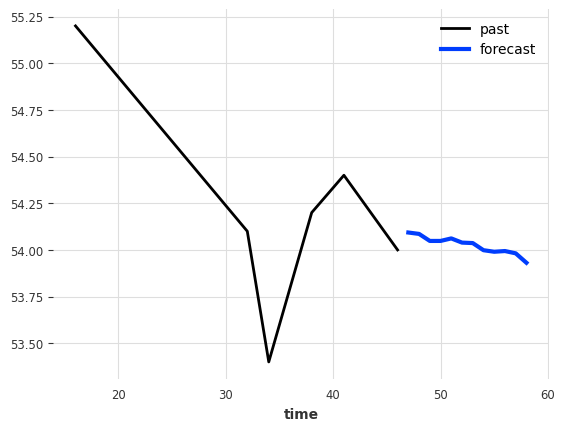

In [19]:
i = np.random.randint(0, len(target))
masked_biometrics_timeseries[i].plot(label='past')
unnorm_preds[i].plot(label='forecast', lw=3)
plt.legend()
plt.show()

Save model and data preprocessor

In [20]:
model.save(WEIGHTS_DIR + "model.pkl")
pickle.dump(preprocess_pipeline, open(WEIGHTS_DIR + 'preprocessor.pkl', 'wb'))
pickle.dump(exercise_scaler, open(WEIGHTS_DIR + 'scaler.pkl', 'wb'))

# Inference

In [21]:
model = RegressionModel.load(WEIGHTS_DIR + "model.pkl")
preprocess_pipeline = pickle.load(open(WEIGHTS_DIR + 'preprocessor.pkl', 'rb'))
scaler = pickle.load(open(WEIGHTS_DIR + 'scaler.pkl', 'rb'))

In [22]:
def pad_timeseries(ts, pad_length, feature_adjustments=None):
    pad_ts = ts.last_values()
    feature_names = ts.columns.tolist()
    if feature_adjustments:
        for feature, adjustment in feature_adjustments:
            feature_stripped = "_".join(feature.split("_")[:-1])
            index = feature_names.index(feature_stripped)
            pad_ts[index] += adjustment
    pad_values = pd.DataFrame(np.tile(pad_ts, (pad_length, 1)))
    return ts.append_values(pad_values)


def preprocess_exercise_data(exercise_data):
    row = exercise_data.iloc[0]
    exercise_types = [x for x in exercise_data.columns if x != "Week"]
    weeks = pd.Index(row['Week']) 
    ex_ts = None
    for col in exercise_types:
        values = row[col]
        ts = TimeSeries.from_times_and_values(
            times=weeks, values=values, columns=[col], freq=1
        )
        ts = darts_fill_na(ts, fill=0.0).astype(np.float32)
        if ex_ts is None:
            ex_ts = ts
        else:
            ex_ts = ex_ts.stack(ts)
    return scaler.transform(ex_ts)

def preprocess_biometric_data(biometric_data, metric):
    row = biometric_data[biometric_data.Biometrics.Name == metric].iloc[0]
    weeks = pd.Index(row.Biometrics["Week"])
    values = row.Biometrics['Value']
    covs = pd.DataFrame(data={ 'Gender': [row[('Gender', '')]], 'Age': [row[('Age', '')]] })
    ts = TimeSeries.from_times_and_values(times=weeks, values=values, columns=[row.Biometrics['Name']], static_covariates=covs, freq=1)
    filled_ts = darts_fill_na(ts, fill='auto').astype(np.float32)
    return preprocess_pipeline.transform(filled_ts)

Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=249) used to fit Scaling. This can result in a mismatch between the series and the underlying transformers.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


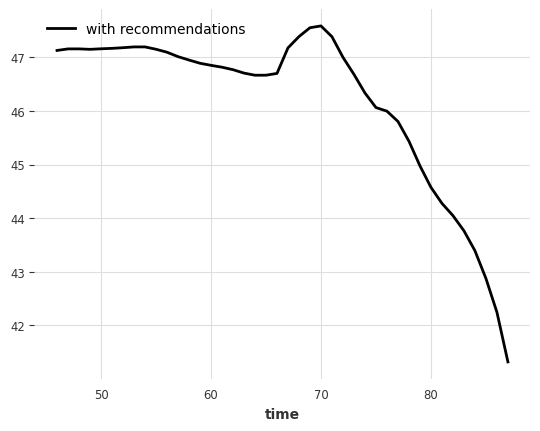

In [23]:
ts_df = pd.read_pickle('processed_dataset.pkl')
ex_df = ts_df[['CloudId', 'Exercise']].drop_duplicates(subset=('CloudId', ''))
bm_df = ts_df[['CloudId', 'Gender', 'Age', 'Biometrics']]

cloud_ids = np.intersect1d(ex_df.CloudId.unique(), bm_df.CloudId.unique())
while True:
    i = np.random.randint(0, len(cloud_ids))
    cloud_id = cloud_ids[i]
    ex_df_filtered = ex_df[ex_df.CloudId == cloud_id]['Exercise']
    bm_df_filtered = bm_df[bm_df.CloudId == cloud_id]
    if TARGET_BM in bm_df_filtered.Biometrics.Name.unique():
        break
        
bm_ts = preprocess_biometric_data(bm_df_filtered, TARGET_BM)
ex_ts = preprocess_exercise_data(ex_df_filtered)

intersected_ex_ts = ex_ts.slice_intersect(bm_ts)
intersected_bm_ts = bm_ts.slice_intersect(ex_ts)

padded_ex_ts = pad_timeseries(intersected_ex_ts, 50, [('total_calories_week_', 10), ('total_minutes_week_', 10), ('cardio_calories_week_', 10), ('cardio_minutes_week_', 10), ('isotonic_calories_week_', 10), ('isotonic_minutes_week_', 10), ('avg_duration_per_workout_', 10), ('avg_calories_per_workout_', 10), ('avg_metsmin_workout_', 10), ('avg_isotonic_workouts_', 10), ('avg_cardio_workouts_', 10)])

pred = model.predict(
            int(np.ceil(4.2 * 10)), [intersected_bm_ts], [padded_ex_ts]
        )
unnorm_pred = preprocess_pipeline.inverse_transform(pred)[0]
unnorm_pred.plot(label='with recommendations')
plt.show()